In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
class simplefunctions:
    def __init__(self, K, actionspace, dim):
        self.K=K
        self.dim=dim
        self.actionspace = actionspace 
        self.subset = self.algorithm()

    def generate_bandits(self, num_samples):
        """
        Generate dim-dimensional zero-mean Gaussian samples with a indentity covariance matrix.
        """
        mean_col = np.zeros(self.dim)
        covariance_matrix = np.eye(self.dim)
        samples = np.random.multivariate_normal(mean=mean_col, cov=covariance_matrix, size=num_samples)
        return samples 

    def algorithm(self):
        subset=[]
        theta_set = self.generate_bandits(self.K)
        for theta in theta_set:
            selected=np.argmax(np.dot(self.actionspace,theta.reshape((self.dim,1))))
            subset = np.append(subset,int(selected))
        subset = np.unique(subset)    
        return [int(i) for i in subset]
    
    def test(self):
        num_batches = 10**4  # Number of function samples for testing
        regret=[]
        theta_set = self.generate_bandits(num_batches)
        for theta in theta_set:
            regret.append(np.max(np.dot(self.actionspace,theta.reshape((self.dim,1))))
                        -np.max(np.dot(self.actionspace[self.subset,:],theta.reshape((self.dim,1)))))
        return np.average(regret)

In [4]:
def random_unit_vector():
    vec = np.random.normal(size=3)
    return vec / np.linalg.norm(vec)

def generate_cluster(center, num_points, spread):
    points = []
    for _ in range(num_points):
        noise = np.random.normal(scale=spread, size=3)
        point = center + noise
        point /= np.linalg.norm(point)  # Project back onto the unit sphere
        points.append(point)
    return np.array(points)

def generate_clusters_on_sphere(n_points=100, num_clusters=3, spread=0.1, center_points=None):
    all_points = []
    labels = []
    points_per_cluster = n_points // num_clusters
    for cluster_id in range(num_clusters):
        if len(center_points)>0:
            center = center_points[cluster_id]
        else:
            center = random_unit_vector()
        cluster_points = generate_cluster(center, points_per_cluster, spread)
        all_points.append(cluster_points)
        labels.extend([cluster_id] * points_per_cluster)
    return np.vstack(all_points) #, np.array(labels)

**Fixed center points by fixing the random seed at "21"**

In [5]:
num_clusters=5
np.random.seed(21)
c = []
for cluster_id in range(num_clusters):
    c.append(random_unit_vector())
center_points=np.vstack(c)

In [14]:
center_points

array([[-0.04953684, -0.10600174,  0.99313128],
       [-0.55853969,  0.33127682, -0.76045321],
       [-0.17587457, -0.20039953,  0.96379882],
       [-0.00839273, -0.40760683,  0.91311896],
       [ 0.85513547, -0.36585132,  0.3672821 ]])

**Generate clusters around center points with the "spread" parameter**

In [10]:
# Generate clusters
points = generate_clusters_on_sphere(n_points=1000, num_clusters=5, spread=0.5, center_points=center_points)

**Figure 1 (right)**

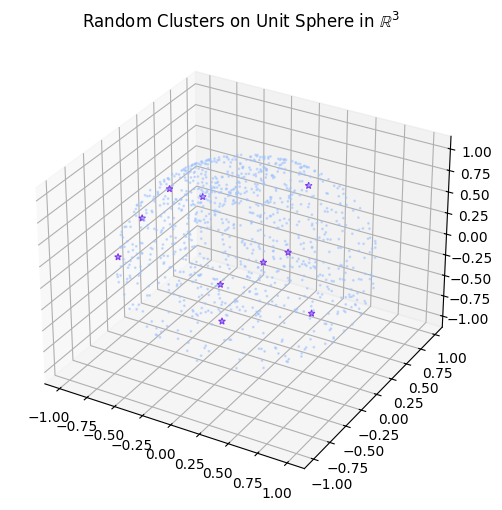

In [13]:
# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(points[:,0], points[:,1], points[:,2],s=1,alpha=0.5,color= "#A0C4FF" )

fun=simplefunctions(K=10,dim=3,actionspace=points)
subset_idx=fun.subset
ax.scatter(points[subset_idx,0], points[subset_idx,1], points[subset_idx,2],marker='*',s=20,alpha=1,color='#8338ec')

ax.set_title("Random Clusters on Unit Sphere in $\mathbb{R}^3$")
plt.show()

**Figure 1 (left)**

In [15]:
K = 10
s_values = np.linspace(0.01,0.5,10)  # Example values for R
results = {}

for s in s_values:
    outputs = []
    for _ in range(30):  # Run multiple trials for statistical robustness
        pts = generate_clusters_on_sphere(n_points=1000, num_clusters=5, spread=s, center_points=center_points)
        fun = simplefunctions(K=K,dim=3,actionspace=pts)
        output = fun.test()
        outputs.append(output)
    outputs = np.array(outputs)
    results[s] = {
        'mean': np.mean(outputs),
        'std': np.std(outputs)
    }

# Print results
for s in results:
    print(f"s = {s}: mean = {results[s]['mean']:.4f}, std = {results[s]['std']:.4f}")

s = 0.01: mean = 0.0331, std = 0.0336
s = 0.06444444444444444: mean = 0.0974, std = 0.0746
s = 0.11888888888888888: mean = 0.1344, std = 0.0386
s = 0.17333333333333334: mean = 0.1743, std = 0.0463
s = 0.22777777777777777: mean = 0.2341, std = 0.0773
s = 0.2822222222222222: mean = 0.2420, std = 0.0593
s = 0.33666666666666667: mean = 0.2706, std = 0.0448
s = 0.3911111111111111: mean = 0.2772, std = 0.0508
s = 0.44555555555555554: mean = 0.2741, std = 0.0409
s = 0.5: mean = 0.2620, std = 0.0354


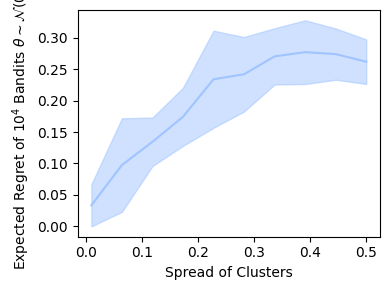

In [21]:
plt.figure(figsize=(4,3))

mean_values = np.array([results[s]['mean'] for s in s_values])
std_values = np.array([results[s]['std'] for s in s_values])

plt.plot(s_values, mean_values, label=f'epsilon = {s}',color="#A0C4FF")  # Mean curve
plt.fill_between(s_values, mean_values - std_values, mean_values + std_values,color="#A0C4FF",alpha=0.5)

# Labeling the plot
# plt.title('Results with Error Shade')
plt.xlabel(r'Spread of Clusters')
plt.ylabel(r'Expected Regret of $10^4$ Bandits $\theta\sim\mathcal{N}(0,I)$')
plt.tight_layout()

# Show the plot
plt.show()

**Figure 1**

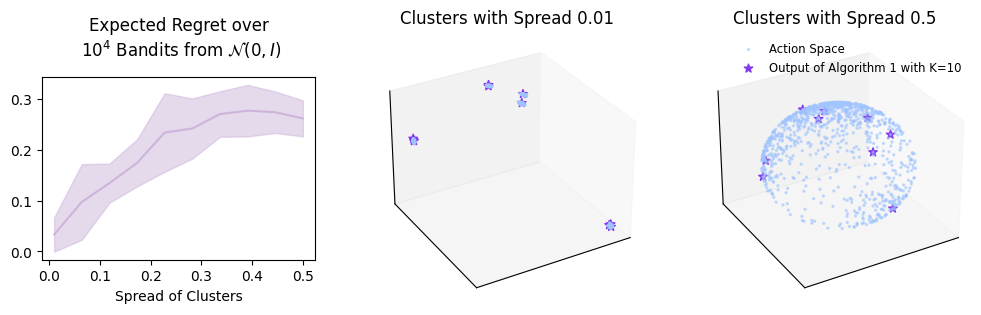

In [17]:
# Start 3 plots in a row
fig = plt.figure(figsize=(12, 6))

# Plot 1 (3D)
points = generate_clusters_on_sphere(n_points=1000, num_clusters=5, spread=0.01, center_points=center_points)
fun=simplefunctions(K=K,dim=3,actionspace=pts)
subset_idx=fun.subset

ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.scatter(points[:,0], points[:,1], points[:,2],s=1,alpha=0.5,color= "#A0C4FF")
ax1.scatter(points[subset_idx,0], points[subset_idx,1], points[subset_idx,2],marker='*',s=40,alpha=1,color='#8338ec')
ax1.set_title("Clusters with Spread 0.01")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([]); ax1.grid(False)
ax1.view_init(elev=30, azim=60)  # Different view

# Plot 2 (3D)
points = generate_clusters_on_sphere(n_points=1000, num_clusters=5, spread=0.5, center_points=center_points)
fun=simplefunctions(K=K,dim=3,actionspace=pts)
subset_idx=fun.subset

ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.scatter(points[:, 0], points[:, 1], points[:, 2], s=2, alpha=0.5, color="#A0C4FF",label='Action Space')
ax2.scatter(points[subset_idx, 0], points[subset_idx, 1], points[subset_idx, 2],marker='*', s=40, alpha=1, color='#8338ec',label='Output of Algorithm 1 with K=10')
ax2.set_title("Clusters with Spread 0.5")
ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_zticks([]); ax2.grid(False)
ax2.legend(loc='upper right', fontsize='small', frameon=False)
ax2.view_init(elev=30, azim=60)  # Different view

# Plot 3
ax3 = fig.add_subplot(1, 3, 1)
mean_values = np.array([results[s]['mean'] for s in s_values])
std_values = np.array([results[s]['std'] for s in s_values])

ax3.plot(s_values, mean_values, label=f'epsilon = {s}',color="#cdb4db")  # Mean curve
ax3.fill_between(s_values, mean_values - std_values, mean_values + std_values,color="#cdb4db",alpha=0.5)
# ax3.set_xticks([]); ax3.set_yticks([])
ax3.set_xlabel(r'Spread of Clusters')
ax3.set_title('Expected Regret over\n $10^4$ Bandits from $\mathcal{N}(0,I)$',pad=15)
# ax3.set_title("2D Projection (x-y)")
ax3.set_aspect('equal')
# ax3.axis('off')

plt.savefig("Clusters.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)
# plt.tight_layout()
plt.show()